In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances

from py.mKMeans import KMeans, KMeansPlus, EnhancedKMeans, SoftKMeans, EnhancedSoftKMeans, silhouette_coefficient
from py.mPCA import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score

def calculate_accuracy(labels_true, labels_pred):
    # 由于聚类标签可能与真实标签的顺序不一致，需要找到最佳匹配
    from scipy.optimize import linear_sum_assignment as linear_assignment
    
    assert labels_true.size == labels_pred.size
    D = max(labels_pred.max(), labels_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    
    # 构建成本矩阵
    for i in range(labels_pred.size):
        w[labels_pred[i], labels_true[i]] += 1

    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) / labels_pred.size


def soft_silhouette_coefficient(X, probabilities, labels):
    print('shape of X:')
    print(X.shape)
    print('shape of probabilities:')
    print(probabilities.shape)
    print('shape of labels:')
    print(labels.shape)
    # 计算所有点的成对距离
    distances = pairwise_distances(X)
    print('shape of distances:')
    print(distances.shape)

    silhouette_scores = []

    for i in range(len(X)):
        # 从隶属度矩阵中获取当前点的隶属度
        current_probabilities = probabilities[i]

        # 计算点i到同聚类内其他点的距离的加权平均值
        mask = np.ones(len(X), dtype=bool)
        mask[i] = False  # 排除点i自己
        same_cluster_distances = distances[i][mask]  # 选择同一聚类内的距离
        same_cluster_probabilities = probabilities[mask, labels[i]]  # 获取相同聚类的隶属度
        a = np.sum(same_cluster_distances * same_cluster_probabilities) / np.sum(same_cluster_probabilities)

        b = np.inf
        # 计算点i到最近的其他聚类的距离的加权平均值
        for j in set(labels) - {labels[i]}:
            other_cluster_distances = distances[i][labels == j]
            other_cluster_probabilities = probabilities[labels == j, j]
            b = min(b, np.sum(other_cluster_distances * other_cluster_probabilities) / np.sum(other_cluster_probabilities))

        # 计算轮廓系数
        s = (b - a) / max(a, b) if max(a, b) > 0 else 0
        silhouette_scores.append(s)

    return np.mean(silhouette_scores)



In [2]:
# read the "seeds_daat.txt", using panda to read conveniently.
import pandas as pd
# def read_seeds_dataset(file_path):
#     try:
#         data = pd.read_csv(file_path, sep='\s+', header=None)
#         # name the dataset
#         data.columns = ['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
#                         'asymmetry_coefficient', 'length_kernel_groove', 'class']
#         return data
#     except Exception as e:
#         return str(e)  

def read_seeds_dataset(file_path):
    try:
        # 使用pandas读取txt文件
        data = pd.read_csv(file_path, sep='\s+', header=None)
        # 给数据集的列命名
        data.columns = ['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                        'asymmetry_coefficient', 'length_kernel_groove', 'class']
        # 分离特征和标签
        features = data.drop('class', axis=1).values
        labels = data['class'].values
        return features, labels
    except Exception as e:
        print("Error reading seeds dataset:", e)
        # 如果出现错误，返回None
        return None, None
    
def draw(labels, centroids, title):
    data_2d = pca_kmeans.transform(seeds_features, 2)
    # 绘制原始数据的分布
    plt.figure(figsize=(12, 5))
    
    # 原始标签图
    plt.subplot(1, 2, 1)
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=seeds_labels, cmap='viridis', marker='o')
    plt.title('Original Data Labels')
    
    # KMeans标签图
    plt.subplot(1, 2, 2)
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', marker='o')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
    plt.title(title)
    plt.legend()
    plt.show()

Then, read out the seeds data.

In [3]:
seeds_features, seeds_labels = read_seeds_dataset('seeds_dataset.txt')
K=10

Now, we're going to examine the KMeansPlus first.

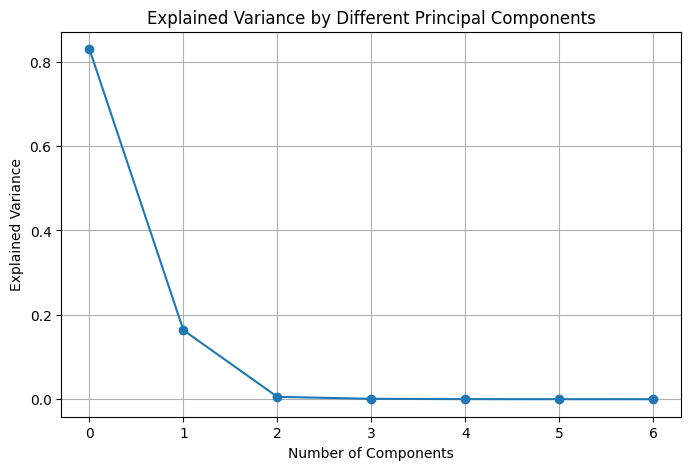

0.37851291616419197
correct rate:  0.41904761904761906


In [4]:
kmeans = KMeansPlus(k=K)
kmeans.fit(seeds_features)
# PCA
pca_kmeans = PCA()
pca_kmeans.train(seeds_features)
pca_kmeans.draw_split_variance_plot()
kmeans_labels = kmeans.predict(seeds_features)
print(silhouette_coefficient(seeds_features, kmeans_labels))
kmeans_corrct = calculate_accuracy(seeds_labels, kmeans_labels)
print('correct rate: ', kmeans_corrct)
# help me test the result, in 2D clursting result.

<Figure size 1800x500 with 0 Axes>

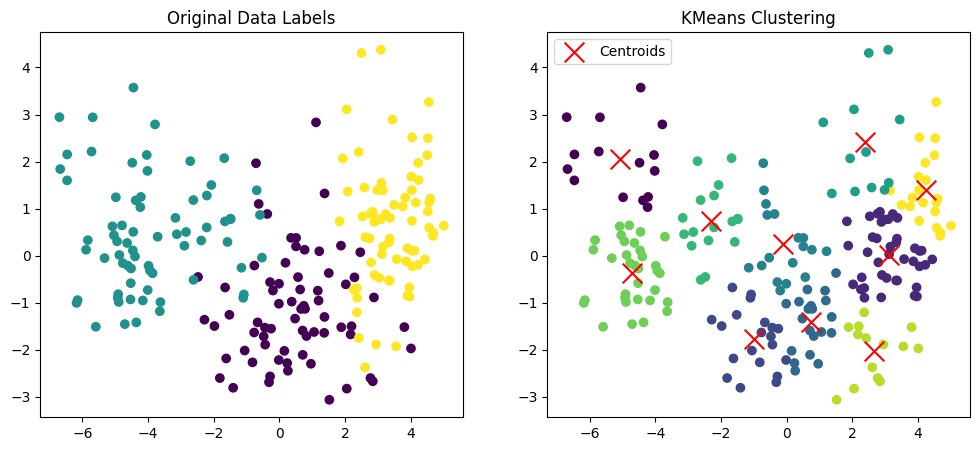

In [5]:
kmeans_data_2d = pca_kmeans.transform(seeds_features, 2)
# 绘制原始数据的分布
plt.figure(figsize=(18, 5))

# 原始标签图
# plt.subplot(1, 2, 1)
# plt.scatter(kmeans_data_2d[:, 0], kmeans_data_2d[:, 1], c=seeds_labels, cmap='viridis', marker='o')
# plt.title('Original Data Labels')
draw(kmeans_labels, pca_kmeans.transform(kmeans.centroids, 2), 'KMeans Clustering')
# KMeans标签图
# plt.subplot(1, 2, 2)
# plt.scatter(kmeans_data_2d[:, 0], kmeans_data_2d[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
# plt.scatter(pca_kmeans.transform(kmeans.centroids,2)[:, 0], pca_kmeans.transform(kmeans.centroids,2)[:, 1], c='red', marker='x', s=200, label='Centroids')
# plt.title('KMeans Clustering')
# plt.legend()
# plt.show()
# SoftKMeans标签图
# plt.subplot(1, 3, 3)
# plt.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
# plt.scatter(pca_kmeans.transform(kmeans.centroids)[:, 0], pca_kmeans.transform(kmeans.centroids)[:, 1], c='red', marker='x', s=200, label='Centroids')
# plt.title('Soft KMeans Clustering')
# plt.legend()

plt.show()

Then comes to SoftKmeans.

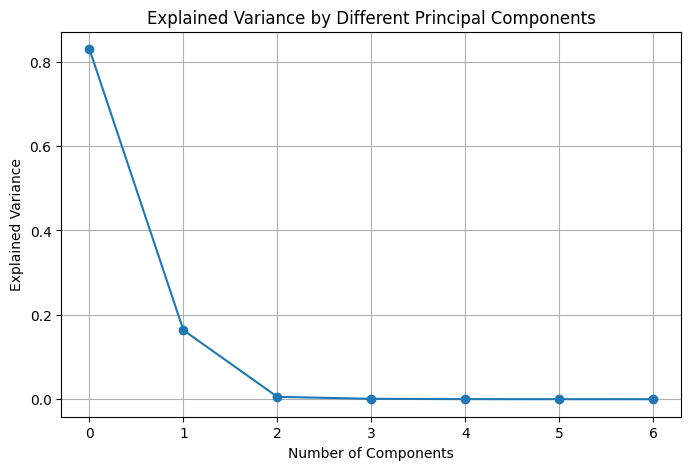

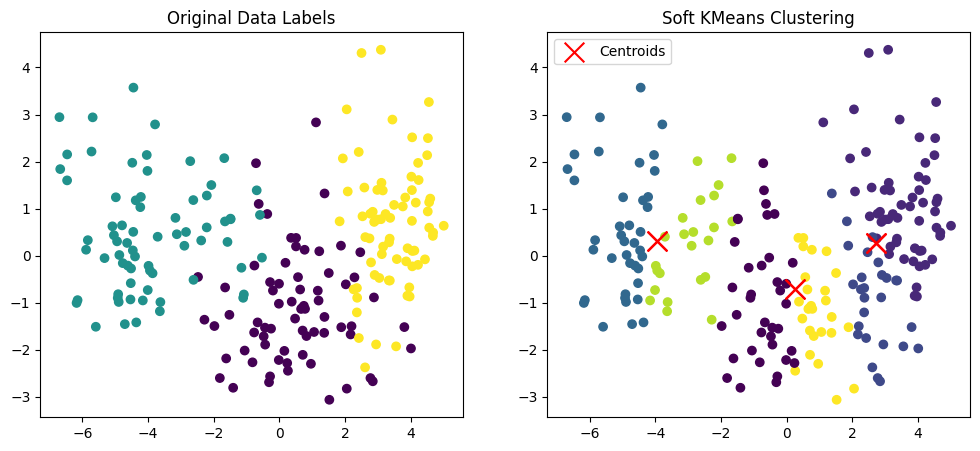

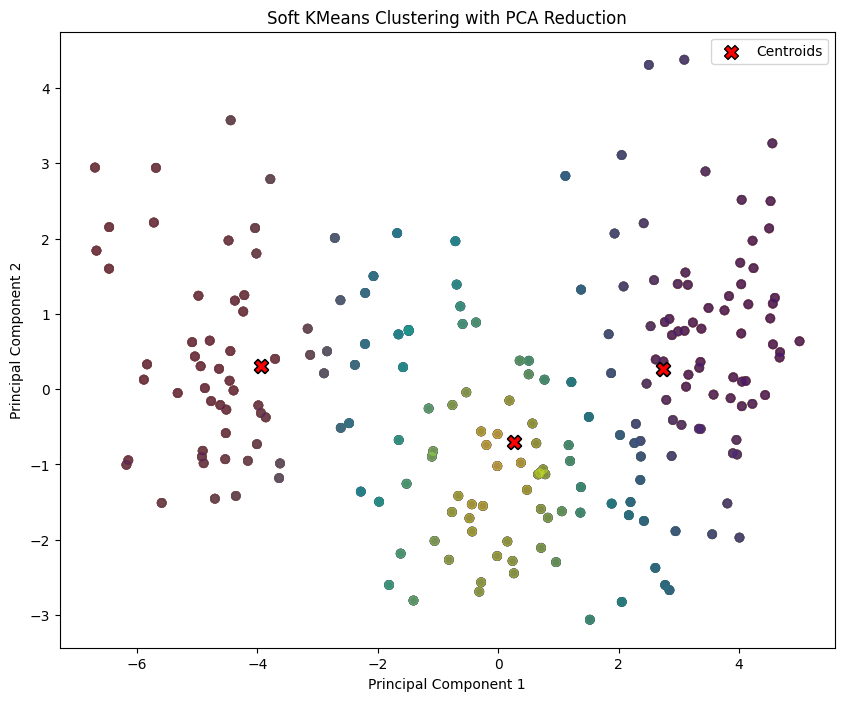

shape of X:
(210, 7)
shape of probabilities:
(210, 10)
shape of labels:
(210,)
shape of distances:
(210, 210)
-0.07205637238034229
correct rate:  0.5857142857142857


In [6]:
soft_kmeans = SoftKMeans(k=K, beta=0.8)
soft_kmeans.fit(seeds_features)

# PCA
pca_soft_kmeans = PCA()
pca_soft_kmeans.train(seeds_features)
pca_soft_kmeans.draw_split_variance_plot()
soft_kmeans_labels = soft_kmeans.predict(seeds_features)
draw(soft_kmeans_labels, pca_soft_kmeans.transform(soft_kmeans.centroids, 2), 'Soft KMeans Clustering')

transformed_features = pca_soft_kmeans.transform(seeds_features, 2)

# 获取隶属度矩阵
probabilities = soft_kmeans.calculate_responsibilities(seeds_features)

# 绘制渐变色的散点图
plt.figure(figsize=(10, 8))
for i in range(probabilities.shape[1]):
    # 提取属于当前聚类的隶属度
    membership_probabilities = probabilities[:, i]
    # 为了可视化效果，我们可以取每个点对应聚类的隶属度作为颜色的透明度
    plt.scatter(transformed_features[:, 0], transformed_features[:, 1],
                c=membership_probabilities, cmap='viridis', alpha=0.5)

# 标记质心位置
centroids_transformed = pca_soft_kmeans.transform(soft_kmeans.centroids, 2)
plt.scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], 
            c='red', edgecolors='black', s=100, marker='X', label='Centroids')

plt.title('Soft KMeans Clustering with PCA Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.colorbar(label='Membership Probability')
plt.legend()
plt.show()

print(soft_silhouette_coefficient(seeds_features, soft_kmeans.calculate_responsibilities(seeds_features), soft_kmeans_labels))
softkmeans_corrct = calculate_accuracy(seeds_labels, soft_kmeans_labels)
print('correct rate: ', softkmeans_corrct)

In [7]:
# SoftKMeans标签图
# plt.subplot(1, 3, 3)
# plt.figure()
# plt.scatter(kmeans_data_2d[:, 0], kmeans_data_2d[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
# plt.scatter(pca_soft_kmeans.transform(soft_kmeans.centroids, 2)[:, 0], pca_soft_kmeans.transform(soft_kmeans.centroids, 2)[:, 1], c='red', marker='x', s=200, label='Centroids')
# plt.title('Soft KMeans Clustering')
# plt.legend()

Then comes to EnhancedKMeans.

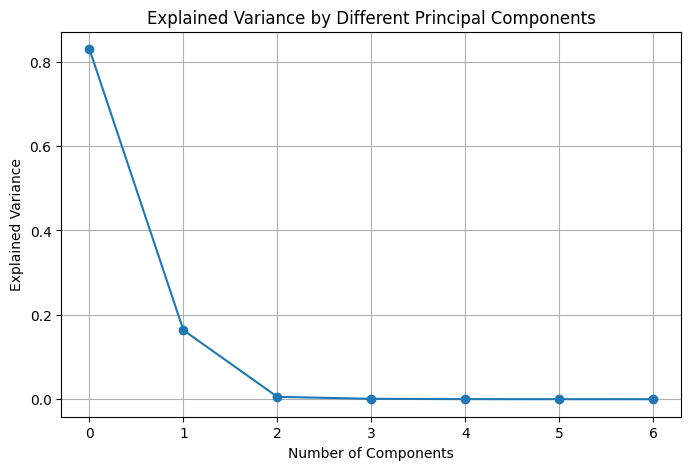

0.479435994292274
correct rate:  0.8952380952380953


In [8]:
enha_kmeans = EnhancedKMeans(k=K, merge_threshold=3, split_threshold=20)

pca_enha_kmeans = PCA()
pca_enha_kmeans.train(seeds_features)
pca_enha_kmeans.draw_split_variance_plot()

# declined_seeds_features = pca_enha_kmeans.transform(seeds_features, 2)
declined_seeds_features = seeds_features.copy()
enha_kmeans.fit(seeds_features)
# enha_kmeans.randFit(declined_seeds_features)
# fit_centroids = pca_enha_kmeans.transform(enha_kmeans.centroids, 2).copy()
fit_centroids = enha_kmeans.centroids.copy()
enha_kmeans_labels = enha_kmeans.predict(declined_seeds_features)
# enha_kmeans = EnhancedKMeans(k=10, merge_threshold=3, split_threshold=10)
# enha_kmeans.randFit(seeds_features)
# rand_centroids = pca_enha_kmeans.transform(enha_kmeans.centroids, 2).copy()
# PCA
print(silhouette_coefficient(seeds_features, enha_kmeans_labels))
enha_kmeans_correct = calculate_accuracy(seeds_labels, enha_kmeans_labels)
print('correct rate: ', enha_kmeans_correct)


Draw.

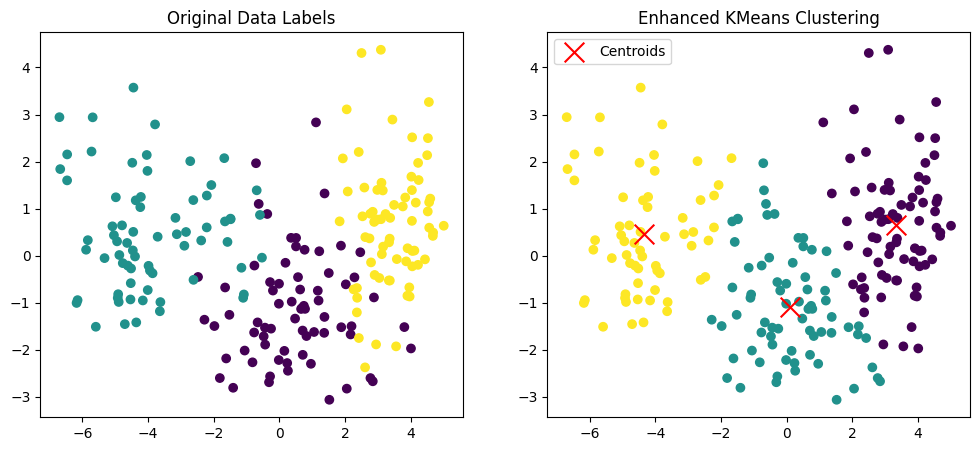

In [9]:
draw(enha_kmeans_labels, pca_enha_kmeans.transform(fit_centroids,2), 'Enhanced KMeans Clustering')
# draw(enha_kmeans.predict(seeds_features), rand_centroids, 'Enhanced KMeans Clustering(Not Up to k Points)')
# draw(enha_kmeans.predict(seeds_features), pca_enha_kmeans.transform(enha_kmeans.centroids, 2), 'Enhanced KMeans Clustering')

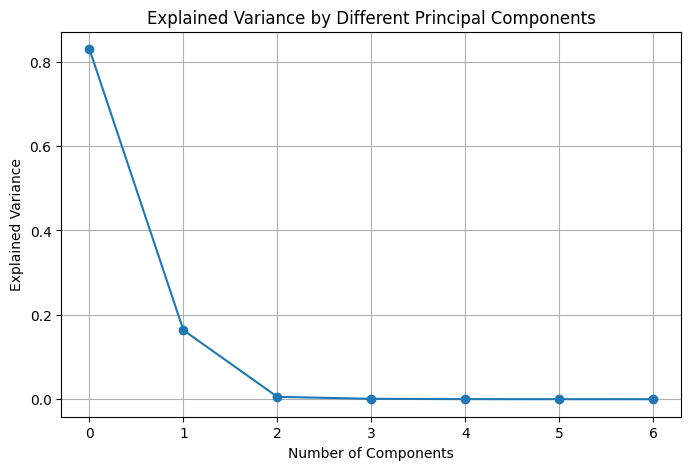

shape of X:
(210, 7)
shape of probabilities:
(210, 2)
shape of labels:
(210,)
shape of distances:
(210, 210)
0.5074255082516306
correct rate:  0.6666666666666666


In [15]:
soft_enha_kmeans = EnhancedSoftKMeans(k=K, merge_threshold=3, split_threshold=20,beta=0.8)

pca_soft_enha_kmeans = PCA()
pca_soft_enha_kmeans.train(seeds_features)
pca_soft_enha_kmeans.draw_split_variance_plot()

# declined_seeds_features = pca_enha_kmeans.transform(seeds_features, 2)
declined_seeds_features = seeds_features.copy()
soft_enha_kmeans.fit(seeds_features)
# enha_kmeans.randFit(declined_seeds_features)
# fit_centroids = pca_enha_kmeans.transform(enha_kmeans.centroids, 2).copy()
fit_centroids = soft_enha_kmeans.centroids.copy()
soft_enha_kmeans_labels = soft_enha_kmeans.predict(declined_seeds_features)
# enha_kmeans = EnhancedKMeans(k=10, merge_threshold=3, split_threshold=10)
# enha_kmeans.randFit(seeds_features)
# rand_centroids = pca_enha_kmeans.transform(enha_kmeans.centroids, 2).copy()
# PCA
enha_probabilities = soft_enha_kmeans.calculate_responsibilities(seeds_features)
print(soft_silhouette_coefficient(seeds_features, enha_probabilities , soft_enha_kmeans_labels))
soft_enha_kmeans_correct = calculate_accuracy(seeds_labels, soft_enha_kmeans_labels)
print('correct rate: ', soft_enha_kmeans_correct)

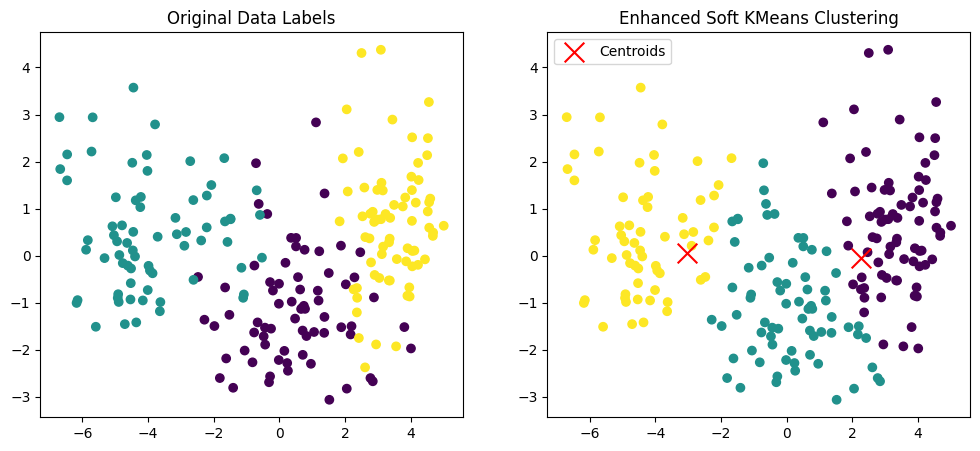

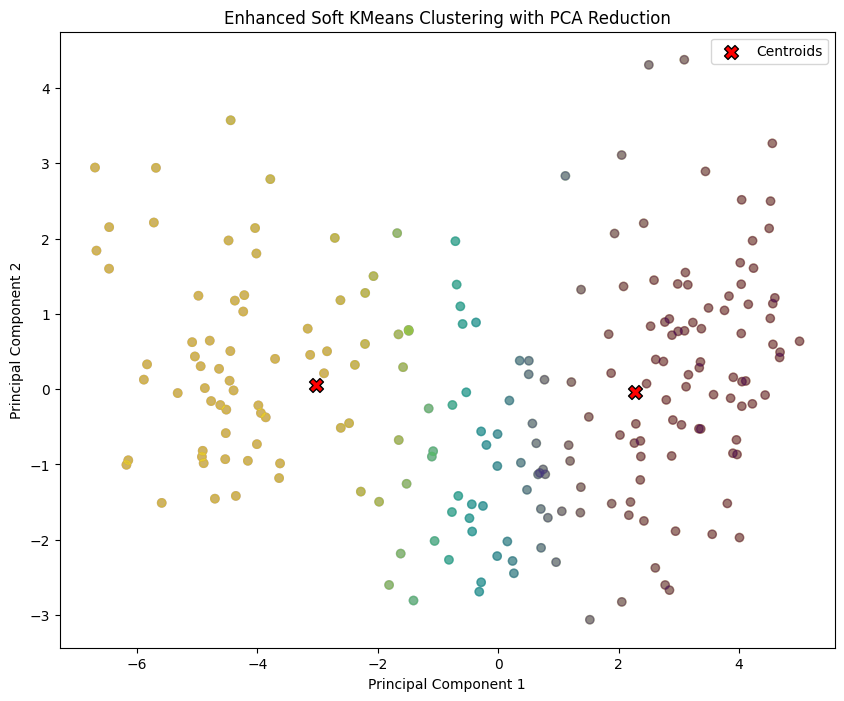

In [16]:
draw(enha_kmeans_labels, pca_enha_kmeans.transform(fit_centroids,2), 'Enhanced Soft KMeans Clustering')
# 绘制渐变色的散点图
plt.figure(figsize=(10, 8))
for i in range(enha_probabilities.shape[1]):
    # 提取属于当前聚类的隶属度
    membership_probabilities = enha_probabilities[:, i]
    # 为了可视化效果，我们可以取每个点对应聚类的隶属度作为颜色的透明度
    plt.scatter(transformed_features[:, 0], transformed_features[:, 1],
                c=membership_probabilities, cmap='viridis', alpha=0.5)

# 标记质心位置
centroids_transformed = pca_soft_enha_kmeans.transform(soft_enha_kmeans.centroids, 2)
plt.scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], 
            c='red', edgecolors='black', s=100, marker='X', label='Centroids')

plt.title('Enhanced Soft KMeans Clustering with PCA Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.colorbar(label='Membership Probability')
plt.legend()
plt.show()